In [71]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna


import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

#По условию задания нельзя использовать более 50 итераций,
# однако этого колличества не хватает для сходимости линейной регресси.
# Поэтому подавляем сообщение о том что модель не длстизла сходимости ConvergenceWarning от sklear
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

%matplotlib inline

In [72]:
#Общий параметр рандома
g_random_state = 77
g_max_iter = 50

In [73]:
#Открываем рабочий набор данных
data = pd.read_csv('data/_train_sem09__1_.zip')

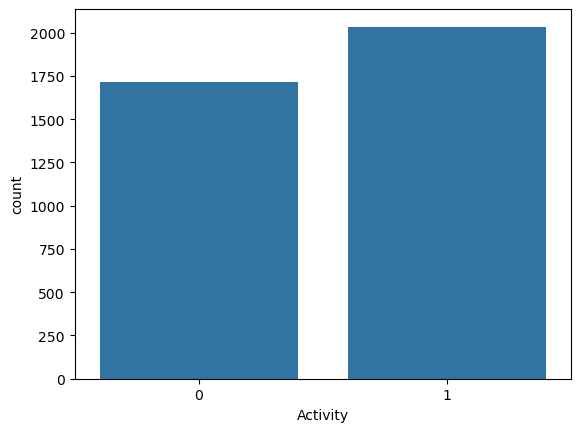

In [74]:
#Оценка баланса выборки
sns.countplot(data=data, x='Activity');

Выборка достаточно сбалансированна.

Согласно условиям задачи рредварительная обработка не требуется, данные уже закодированы и нормализованы.

Обучаеам модели на дефолтных параметрах

In [75]:
#Формируем матрицу наблюдений
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [76]:
#Разделяем выборку на тренировочную и тестовую в соотношении 80/20.
#Учитывая не плохую сбалансированность выборки не будем использовать стратифицированное разбиение.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = g_random_state, test_size = 0.2)

#### Логистическая регрессия

In [77]:
#Логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = g_max_iter)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.77


In [78]:
#Задаем пространство гиперпараметров
param_grid = [
             {'penalty': [None], # тип регуляризации
              'solver': ['lbfgs', 'newton-cg'], # алгоритм оптимизации
               'class_weight': [None,'balanced']
            }, #вес классов

              {'penalty': ['l1'], # тип регуляризации
              'solver': ['liblinear','saga'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float)), # уровень силы регурялизации
               'class_weight': [None,'balanced']
            },

              {'penalty': ['l2'],
              'solver': ['lbfgs','liblinear','newton-cg','saga','sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float)),
               'class_weight': [None,'balanced']
            },

               {'penalty': ['elasticnet'],
              'solver': ['saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float)),
               'class_weight': [None,'balanced'],
               'l1_ratio': [0.1, 0.5, 0.9]}
]

In [79]:
#Подбор параметров по сетке GridSearchCV
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
                                    random_state=g_random_state, #генератор случайных чисел
                                    max_iter=g_max_iter #количество итераций на сходимость
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)
%time grid_search.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

CPU times: total: 32.4 s
Wall time: 11min 20s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': np.float64(0.01), 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'}
Наилучшая модель:
LogisticRegression(C=np.float64(0.01), max_iter=50, random_state=77,
                   solver='sag')
Наилучшее значение точности при кросс-валидаци: 0.76


Подбор параметров по сетке позволил немного улучшить показатели качества модели

In [80]:
#использование RandomizedSearchCV
random_search = RandomizedSearchCV(
                                estimator=linear_model.LogisticRegression(random_state=g_random_state, max_iter=g_max_iter),
                                param_distributions=param_grid,
                                cv=5,
                                n_iter = 10,
                                n_jobs = -1
                            )

%time random_search.fit(X_train, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))
print("Наилучшая модель:\n{}".format(random_search.best_estimator_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(random_search.best_score_))

CPU times: total: 5.47 s
Wall time: 24.5 s
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.5, 'class_weight': None, 'C': np.float64(0.23)}
Наилучшая модель:
LogisticRegression(C=np.float64(0.23), l1_ratio=0.5, max_iter=50,
                   penalty='elasticnet', random_state=77, solver='saga')
Наилучшее значение точности при кросс-валидаци: 0.76


Случайный поиск подобрал набор гиперпараметров обеспечивающих качество модели аналогичное поиску по сетке, но затратил времени в разы меньше

In [81]:
#Общее простанство гиперпараметров для Логистической регрессии
space_lr = {
    'C': hp.quniform('C', 0.01, 1, 0.01),  # шкала 0.01–1 с шагом 0.01
    'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', None]),
    'solver': hp.choice('solver', ['liblinear', 'saga', 'sag','lbfgs','newton-cg']),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'l1_ratio': hp.quniform('l1_ratio', 0.1, 1, 0.1)
}

choice_maps = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'solver': ['liblinear', 'saga', 'sag', 'lbfgs', 'newton-cg'],
    'class_weight': [None, 'balanced']
}

In [82]:
def valid_param_lr(params):
    """Проверка согласованности ключевых параметров регрессии"""
    retVal = True

    if params['penalty'] == 'elasticnet' and params['solver'] != 'saga':
        retVal = False

    if params['penalty'] == None and not params['solver'] in ['lbfgs','newton-cg']:
        retVal = False

    if params['penalty'] == None and params['solver'] == 'liblinear':
        retVal = False

    if params['penalty'] == None and params['C'] > 0:
        retVal = False

    if params['penalty'] == 'l1' and not params['solver'] in ['liblinear','saga']:
        retVal = False

    if params['penalty'] == 'l2' and not params['solver'] in ['lbfgs','liblinear','newton-cg','sag']:
        retVal = False


In [83]:
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, p_random_state=g_random_state, p_max_iter = g_max_iter):
    # функция получает комбинацию гиперпараметров в "params"


    param = {'penalty': params['penalty'],
             'solver': params['solver'],
             'C': float(params['C']),
             'class_weight': params['class_weight'],
             'l1_ratio': float(params['l1_ratio'])
            }

    #Если комбинация параметров прошла проуерку на корректность
    if valid_param_lr(param):
        # используем эту комбинацию для построения модели
        model = linear_model.LogisticRegression(**param,
                                                random_state=p_random_state,
                                                max_iter=p_max_iter,
                                                verbose=0
                                            )

        # обучаем модель
        model.fit(X, y)
        #score = metrics.f1_score(y, model.predict(X))

        # применим  cross validation с заданным количеством фолдов
        score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    else:
        score = 0 #Если комбинацичя не прошла проверку на корректность то вернем 0

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [84]:
%%time
# подбор гиперпараметров с использованием Hyperopt

trials = Trials() # используется для логирования результатов

best_param=fmin(hyperopt_lr, # наша функция
               space=space_lr, # пространство гиперпараметров
               algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
               max_evals=g_max_iter, # максимальное количество итераций
               trials=trials, # логирование результатов
               rstate=np.random.default_rng(g_random_state)# фиксируем для повторяемости результата
            )
print("Наилучшие значения гиперпараметров {}".format(best_param))

100%|██████████| 50/50 [00:00<00:00, 104.33trial/s, best loss: 0.0]
Наилучшие значения гиперпараметров {'C': np.float64(0.77), 'class_weight': np.int64(1), 'l1_ratio': np.float64(0.7000000000000001), 'penalty': np.int64(3), 'solver': np.int64(4)}
CPU times: total: 484 ms
Wall time: 494 ms


In [85]:
# рассчитаем точность для тестовой выборки
log_res_best = linear_model.LogisticRegression(
    penalty=choice_maps['penalty'][best_param['penalty']],
    solver=choice_maps['solver'][best_param['solver']],
    C=float(best_param['C']),
    class_weight= choice_maps['class_weight'][best_param['class_weight']],
    l1_ratio=float(best_param['l1_ratio']),
    random_state=g_random_state,
    max_iter=g_max_iter
)
log_res_best.fit(X_train, y_train)
y_train_pred = log_res_best.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(log_res_best.score(X_test, y_test)))
y_test_pred = log_res_best.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

c:\myProgram\Python\anaconda3\envs\myConda_env_312\Lib\site-packages\sklearn\linear_model\_logistic.py:1213: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
c:\myProgram\Python\anaconda3\envs\myConda_env_312\Lib\site-packages\sklearn\linear_model\_logistic.py:1224: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


f1_score на обучающем наборе: 1.00
accuracy на тестовом наборе: 0.70
f1_score на тестовом наборе: 0.72


Hyperot потратил меньше времени на подбор параметров, но не смог улучшить нашу метрику

In [86]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров

  l_penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
  l_l1_ratio = None

  # Подбираем solver в зависимости от penalty
  if l_penalty == 'l1':
     l_solver = trial.suggest_categorical('solver_l1', ['liblinear', 'saga'])
  elif l_penalty == 'l2':
      l_solver = trial.suggest_categorical('solver_l2', ['newton-cg', 'lbfgs', 'sag', 'saga'])
  elif l_penalty == 'elasticnet':
      l_solver = 'saga'  # только saga поддерживает elasticnet
      l_l1_ratio=trial.suggest_float('l1_ratio',0.1, 1, step=0.1)

  l_C=trial.suggest_float('C', 0.01, 1, step=0.01)
  l_class_weight=trial.suggest_categorical('class_weight',[None, 'balanced'])


  # создаем модель
  opti_lr = linear_model.LogisticRegression(penalty=l_penalty,
                                            solver=l_solver,
                                            C=l_C,
                                            class_weight=l_class_weight,
                                            l1_ratio = l_l1_ratio,
                                            random_state=g_random_state,
                                            max_iter=g_max_iter
                                          )
  # обучаем модель
  opti_lr.fit(X_train, y_train)
  #score = metrics.f1_score(y_train, opti_lr.predict(X_train))

  # применим  cross validation использованием 5 фолдов
  score = cross_val_score(opti_lr, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [87]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2026-01-09 17:11:10,497] A new study created in memory with name: LogisticRegression
[I 2026-01-09 17:11:18,073] Trial 0 finished with value: 0.7789055391192046 and parameters: {'penalty': 'l2', 'solver_l2': 'saga', 'C': 0.4, 'class_weight': None}. Best is trial 0 with value: 0.7789055391192046.
[I 2026-01-09 17:11:28,511] Trial 1 finished with value: 0.7761238982396063 and parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.2, 'C': 0.33, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7789055391192046.
[I 2026-01-09 17:11:40,246] Trial 2 finished with value: 0.7775572446566771 and parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.9, 'C': 0.6, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7789055391192046.
[I 2026-01-09 17:11:51,955] Trial 3 finished with value: 0.7801039112765406 and parameters: {'penalty': 'elasticnet', 'l1_ratio': 0.30000000000000004, 'C': 0.8200000000000001, 'class_weight': None}. Best is trial 3 with value: 0.7801039112765406.
[I 2026-

CPU times: total: 1min 18s
Wall time: 2min 55s


In [88]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'elasticnet', 'l1_ratio': 0.5, 'C': 0.23, 'class_weight': None}
f1_score на обучающем наборе: 0.79


In [ ]:
# рассчитаем точность для тестовой выборки
params = dict(study.best_params)

if 'solver_l1' in list(params.keys()):
    params['solver'] = params.pop('solver_l1')
if 'solver_l2' in list(params.keys()):
   params['solver'] = params.pop('solver_l2')

if params['penalty'] == 'elasticnet' and not 'solver' in params:
    params['solver'] = 'saga'

model_opt_lr = linear_model.LogisticRegression(**params,
                                        random_state=g_random_state,
                                        max_iter=g_max_iter)
model_opt_lr.fit(X_train, y_train)
y_train_pred = model_opt_lr.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model_opt_lr.score(X_test, y_test)))
y_test_pred = model_opt_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

{'penalty': 'elasticnet', 'l1_ratio': 0.5, 'C': 0.23, 'class_weight': None, 'solver': 'saga'}
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


#### Случайный лес

In [95]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=g_random_state)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.83


In [96]:
#Формирвем пространство гиперпараметров
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }

#### Подбор гиперпараметров случайного леса по сетке

In [97]:
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)
%time grid_search_forest.fit(X_train, y_train)
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 5 s
Wall time: 39.9 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': np.int64(30), 'min_samples_leaf': 5, 'n_estimators': 110}


#### Подбор гиперпараметров случайного леса с использованием случайного поиска по сетке

In [98]:
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    cv=5,
    n_iter = 10,
    n_jobs = -1
)
%time random_search_forest.fit(X_train, y_train)
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 3.67 s
Wall time: 19 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 5, 'max_depth': np.int64(30)}


##### Используем Hyperopt для случайного леса

In [99]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [100]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])
              }

    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params,
                                            random_state=g_random_state)

    # обучаем модель
    model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))

    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [101]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(g_random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [02:06<00:00,  6.31s/trial, best loss: -0.8117209044131879]
Наилучшие значения гиперпараметров {'max_depth': np.float64(21.0), 'min_samples_leaf': np.float64(3.0), 'n_estimators': np.float64(142.0)}
CPU times: total: 1min 10s
Wall time: 2min 6s


In [102]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=g_random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.98
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.83


#### Используем Optuna для поиска оптимальной комбинации гиперпараметров случайного леса

In [103]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, step=10)
  max_depth = trial.suggest_int('max_depth', 15, 40, step=1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, step=1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  #score = metrics.f1_score(y_train, model.predict(X_train))

  # применим  cross validation использованием 5 фолдов
  score = cross_val_score(model, X, y, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [104]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2026-01-09 17:26:58,283] A new study created in memory with name: RandomForestClassifier
[I 2026-01-09 17:27:05,885] Trial 0 finished with value: 0.8056420313971433 and parameters: {'n_estimators': 160, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8056420313971433.
[I 2026-01-09 17:27:19,076] Trial 1 finished with value: 0.8089378216867334 and parameters: {'n_estimators': 260, 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8089378216867334.
[I 2026-01-09 17:27:25,366] Trial 2 finished with value: 0.8008913624775467 and parameters: {'n_estimators': 130, 'max_depth': 31, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8089378216867334.
[I 2026-01-09 17:27:37,750] Trial 3 finished with value: 0.803571596873285 and parameters: {'n_estimators': 270, 'max_depth': 34, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8089378216867334.
[I 2026-01-09 17:27:49,906] Trial 4 finished with value: 0.8041729689030479 and parameters: {'n_e

CPU times: total: 1min 59s
Wall time: 3min 50s


In [105]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 190, 'max_depth': 24, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.82


In [106]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=g_random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.84
